In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
#from mlxtend.frequent_patterns import apriori
from apyori import apriori 
from itertools import combinations, groupby
from collections import Counter
from Server_Assign_apriori import server_association_apriori
from format_rules_apriori import  format_rules_apriori
from assign_test_apriori import assign_servers_output
from apriori_rules import association_rules

In [2]:
#load data
# based off https://www.datatheque.com/posts/association-analysis/

client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()))


/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")

In [4]:
def convert_si_to_number(x):
    total_stars = 0
    if 'k' in x:
        if len(x) > 1:
            total_stars = float(x.replace('k', '')) * 1000 # convert k to a thousand
    elif 'M' in x:
        if len(x) > 1:
            total_stars = float(x.replace('M', '')) * 1000000 # convert M to a million
    elif 'B' in x:
        total_stars = float(x.replace('B', '')) * 1000000000 # convert B to a Billion
    else:
        total_stars = int(x) # Less than 1000
    return int(total_stars)

In [5]:
df.Bytes=df.Bytes.astype('str')
test_list=df.Bytes

[i for i, s in enumerate(test_list) if 'M' in s]#show where the M errors are happening

test_list= [convert_si_to_number(x) for x in test_list]
df.Bytes=test_list #bring it back into the dataframe


In [6]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])

In [7]:
df['norm_latency']=df['Duration']/df['Packets']

In [8]:
df_train=df[df['Date']<'2017-08-08'] #first 6 days
df_test=df[df['Date']>'2017-08-08'] #last day

In [9]:
percentile=0.9
confidence=0 #allow all rules to pass
apps_server=20

In [10]:
server_df, server_assignments, total_latency, total_latency_model, avg_latency, avg_latency_model =assign_servers_output(df_train=df_train, df_test=df_test, percentile=percentile, confidence=confidence, apps_server=apps_server)

/home/ubuntu/notebook/Manifold_Final/assign_test_apriori.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=None
/home/ubuntu/notebook/Manifold_Final/assign_test_apriori.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=pd.DatetimeIndex(df_train['Date']).hour


Starting order_item:               12710576
Items with support >= 3.807852610298699e-05:            8493
Remaining order_item:              12710576
Remaining orders with 2+ items:     5229106
Remaining order_item:              12710576


/home/ubuntu/notebook/Manifold_Final/iter_apriori.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           75258
Item pairs with support >= 3.807852610298699e-05:      24490



In [11]:
server_df['hour']=None
server_df['hour']=pd.DatetimeIndex(server_df['Date']).hour

In [12]:
#xport server assignments for later use
server_assignments.to_csv('server_assignments_90percentile_Apriori_testday.csv')

In [12]:
#sum up by an hourly timestep, get the average transaction time (s)

server_df_hour=server_df.groupby('hour')[['Duration', 'duration_pred']].mean().reset_index()

In [13]:
server_df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,norm_latency,Src_Server,Dst_Server,duration_pred,hour
0,2017-08-08 00:00:00.760,0.144,10692_129,443,192.168.210.54,52204.0,3,936,2017-08-08,"[10692_129, 192.168.210.54]","(10692_129, 192.168.210.54)",0.0480,NaN,4.0,0.144,0
1,2017-08-08 00:00:00.746,0.158,192.168.210.54,52204,10692_129,443.0,2,334,2017-08-08,"[10692_129, 192.168.210.54]","(10692_129, 192.168.210.54)",0.0790,4.0,NaN,0.158,0
2,2017-08-08 00:00:02.205,0.000,11948_124,80,192.168.220.51,40971.0,1,279,2017-08-08,"[11948_124, 192.168.220.51]","(11948_124, 192.168.220.51)",0.0000,NaN,0.0,0.000,0
3,2017-08-08 00:00:02.126,0.023,DNS,53,192.168.220.51,54811.0,2,371,2017-08-08,"[192.168.220.51, DNS]","(192.168.220.51, DNS)",0.0115,0.0,0.0,0.000,0
4,2017-08-08 00:00:02.098,0.031,192.168.220.51,54811,DNS,53.0,2,156,2017-08-08,"[192.168.220.51, DNS]","(192.168.220.51, DNS)",0.0155,0.0,0.0,0.000,0


### How many rules did we create for our test day?

In [14]:
len(server_assignments)

226

This means the next day we assigned 226 rules that were in effect the whole 24 hours

This is what percentage of IPs assigned:

In [15]:
unique_IPs=server_df['Src_IP'].nunique()+server_df['Dst_IP'].nunique()
len(server_assignments)/unique_IPs

0.023091856544395627

In [16]:
#What was the latency reduction? %
(total_latency- total_latency_model)/  total_latency

0.2642127380851742

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


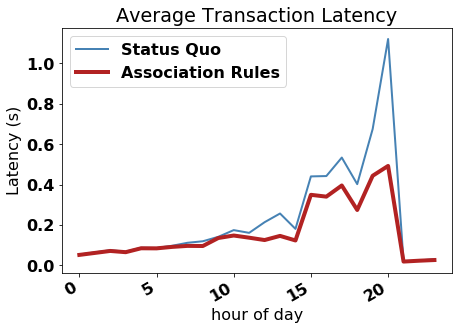

In [17]:
#plot average transaction time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib as matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(server_df_hour['hour'], server_df_hour['Duration'], color='steelblue', linewidth=2.0, label='Status Quo')
ax.plot(server_df_hour['hour'], server_df_hour['duration_pred'], color='firebrick', linewidth=4.0, label='Association Rules')


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency')
plt.legend(loc='upper left')
fig.savefig('Figures/Average_transaction_latency_Apriori.png')

## How much money did we save in this example test day?

the reason why I provided you with bandwidth pricing is the following:
If applications are co-located you pay nothing
so you can caulcute the price by using the bytes transmitted and recieved (as per the dataset)
and just put 0 for any machine that is co-located

Bandwidth is charged on a pay-as-you-go basis, and it is calculated on the actual bandwidth usage (GB) in your last month multiplied by AWS bandwidth charges ($0.12 / GB). For example, if your server consumed 100GB bandwidth in the month, you will be charged for $12 (100GB x $0.12).https://support.cloudways.com/aws-bandwidth-charges/

BAndwith measured in bytes/second. so if we sum up the bytes over a period of time, we can know the min bandwith we would need to order and pay for.

Assume $0.12/GB of data transferred.
If latency = 0, then we will set Bytes=0 b/c we did not have to really transfer them and no need to allocate extra bandwith..
To calculate original cost = Sum up the Bytes, multiply by this $rate

To calculate the model cost, we will set any byte where servers match =0, then sum up bytes and multipy by $rate.


In [18]:
cost_rate=0.12
server_df['Bytes_model']=server_df['Bytes']
server_df.loc[server_df['Src_Server']==server_df['Dst_Server'], 'Bytes_model']=0
orig_GB=(server_df['Bytes'].sum()/10E9)#convert from byte to GB, this is over the test period in 'hours' below
model_GB=(server_df['Bytes_model'].sum()/10E9)
time=(server_df['Date'].iloc[-1]-server_df['Date'][0]).total_seconds() #total time in seconds
hours=time//3600 #total time in hours

In [19]:
orig_GB

4.7446498244

In [20]:
(orig_GB)/hours #Mb/s

0.20628912279999997

In [21]:
(model_GB*10E3)/time

0.30632015713864647

In [22]:
orig_bandrate=orig_GB/time
model_bandrate=model_GB/time

orig_cost=((orig_GB)/hours) *24*365*cost_rate # $/yr
model_cost=((model_GB)/hours) *24*365*cost_rate

In [23]:
orig_cost

216.85112588735996

In [24]:
model_cost

120.95624932910609

In [25]:
(orig_cost-model_cost)/orig_cost

0.4422152578910981

## How does this model compare to random assignment?


In [26]:
#Need to assign random servers to the IP addressed, however b/c we did not assign a server to all the IP addresses in our model run, we will only assign servers to the same proportion of the data.

#How many servers did we assign in the Src_server column?
num_src_assign=server_df['Src_Server'].count()
num_dst_assign=server_df['Dst_Server'].count()


In [27]:
xx_src=np.random.choice(len(df_test), num_src_assign) #which rows are randomly assigned src servers
xx_dst=np.random.choice(len(df_test), num_dst_assign) #which rows are randomly assigned dst servers
num_servers=server_assignments['serverid'].nunique()
server_df['rnd_src_server']=None
server_df['rnd_dst_server']=None

In [28]:
rnd_src_servers=[]
for x in range(len(xx_src)):
  rnd_src_servers.append(random.randint(0,num_servers))

rnd_dst_servers=[]
for x in range(len(xx_dst)):
  rnd_dst_servers.append(random.randint(0,num_servers)) #create random numbers for dst serve

In [29]:
server_df['rnd_src_server'][xx_src]=rnd_src_servers
server_df['rnd_dst_server'][xx_dst]=rnd_dst_servers

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [30]:
len(server_df[server_df.rnd_src_server==server_df.rnd_dst_server])/len(server_df) #we get 1% matches

0.016224905828577423

In [31]:
server_df['duration_rnd']=server_df['Duration']
server_df['duration_rnd'][server_df['rnd_src_server']==server_df['rnd_dst_server']]=0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [32]:
random_reduction=(server_df['Duration'].sum()-server_df['duration_rnd'].sum())/ server_df['Duration'].sum() #new updated latency with the random assignment

In [33]:
model_reduction=(server_df['Duration'].sum()-server_df['duration_pred'].sum())/ server_df['Duration'].sum() 

In [34]:
latency_matrix=pd.DataFrame([random_reduction, model_reduction], ['Random Assignment', 'Association Rules'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


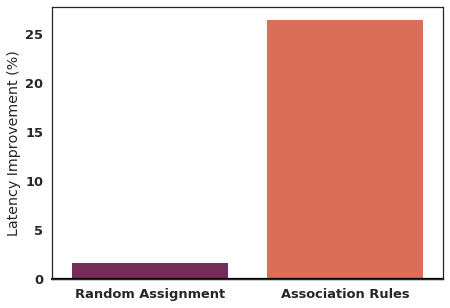

In [35]:
import seaborn as sns
sns.set(style="white", context="talk")
rs = np.random.RandomState(8)
matplotlib.rc('font', **font)
# Set up the matplotlib figure
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

sns.barplot(x=latency_matrix.index, y=latency_matrix[0]*100, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Latency Improvement (%)")
fig.savefig('Figures/Overall_Latency_Improvement_apriori_test_bar.png')

Average transaction latency reduction:

In [36]:
avg_latency-avg_latency_model

0.07306354222197572

In [37]:
(avg_latency-avg_latency_model)/avg_latency

0.2642127380851149

## What if we want to optimize our selection, can we modify the min threshold to accomplish our latency reduction goals?

In [38]:
percentiles=[0.25, 0.5, 0.75, 0.9]
confidences=np.linspace(0,.8,4,endpoint=False)
apps_server=20

In [39]:
percentiles

[0.25, 0.5, 0.75, 0.9]

In [40]:
pairs_count=(df_train.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())
pairs_count.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair

In [41]:
len_apps_assigned=[]
total_latency_model_list=[]
avg_latency_list=[]
avg_latency_model_list=[]
latency_reduction_list=[]
percentile_list=[]
confidence_list=[]

groups=[]
for i in percentiles:
    for j in confidences:
        per_n=(pairs_count['frequency'].quantile(i))
        server_df, server_assignments, total_latency, total_latency_model, avg_latency, avg_latency_model =assign_servers_output(df_train=df_train, df_test=df_test, percentile=i, confidence=j, apps_server=apps_server)
        len_apps_assigned.append(len(server_assignments))
        total_latency_model_list.append(total_latency_model)
        avg_latency_model_list.append(avg_latency_model)
        latency_red=((total_latency-total_latency_model)/total_latency)
        latency_reduction_list.append(latency_red)
        percentile_list.append(i)
        confidence_list.append(j)
        print(per_n)


/home/ubuntu/notebook/Manifold_Final/assign_test_apriori.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=None
/home/ubuntu/notebook/Manifold_Final/assign_test_apriori.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=pd.DatetimeIndex(df_train['Date']).hour


Starting order_item:               12710576
Items with support >= 2.045540658424921e-06:            8493
Remaining order_item:              12710576
Remaining orders with 2+ items:     5229106
Remaining order_item:              12710576


/home/ubuntu/notebook/Manifold_Final/iter_apriori.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           75258
Item pairs with support >= 2.045540658424921e-06:      75258

13.0
Starting order_item:               12710576
Items with support >= 2.045540658424921e-06:            8493
Remaining order_item:              12710576
Remaining orders with 2+ items:     5229106
Remaining order_item:              12710576
Item pairs:                           75258
Item pairs with support >= 2.045540658424921e-06:      75258

13.0
Starting order_item:               12710576
Items with support >= 2.045540658424921e-06:            8493
Remaining order_item:              12710576
Remaining orders with 2+ items:     5229106
Remaining order_item:              12710576
Item pairs:                           75258
Item pairs with support >= 2.045540658424921e-06:      75258

13.0
Starting order_item:               12710576
Items with support >= 2.045540658424921e-06:            8493
Remaining order_item:              12710576
Remaining orders with 2+ items:     5229106


In [43]:
optimize_df=pd.DataFrame({'percentile':percentile_list, 'confidence': confidence_list,'num_apps_assigned':len_apps_assigned,'model_latency':total_latency_model_list, 'latency_reduction':latency_reduction_list})

In [49]:
optimize_df

,percentile,confidence,num_apps_assigned,model_latency,latency_reduction
0,0.25,0.0,869,410870.402,1.884043e-01
1,0.25,0.2,4,506250.060,3.358024e-08
2,0.25,0.4,0,506250.077,0.000000e+00
3,0.25,0.6,0,506250.077,0.000000e+00
4,0.50,0.0,869,410870.402,1.884043e-01
5,0.50,0.2,4,506250.060,3.358024e-08
6,0.50,0.4,0,506250.077,0.000000e+00
7,0.50,0.6,0,506250.077,0.000000e+00
8,0.75,0.0,869,410870.402,1.884043e-01
9,0.75,0.2,4,506250.060,3.358024e-08


This is showing that we do not alter how many apps are assigned until we cross the 70th percentile min support level. This means 869 apps occur more frequently than the 70th percentile, but only 226 occur more than the 85th percentile.

Because it get's harder to ensure that important apps are co-located with more apps to assign to servers (because a server fills up at 20 apps), it actually improves performance (leads to greater latency reduction)